In [1]:
import cv2
import numpy as np
import cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os
from matplotlib import pyplot as plt

Libraries are now imported

Parameters

In [2]:
NUMBER_OF_SIFT_FEATURES = 800
VOCABULARY_SIZE = 128
NUMBER_OF_NEIGHBOURS = 15
DISTANCE_METRIC = 'braycurtis'

We now load the image data

In [3]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

In [4]:
train_images_filenames[0]

'../../Databases/MIT_split/train/Opencountry/art582.jpg'

1. We create a SIFT object detector and descriptor.
2. Compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together.
3. Compute a k-means clustering on the descriptor space
4. For each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.
5. We build a k-nn classifier and train it with the train descriptors
6. Compute the test descriptors and compute the accuracy of the model

In [5]:
result = []
sift_features = [100,250,500,600,700,800,1000,1250,1500]
for n,nosf in enumerate(sift_features):
    SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=nosf)
    Train_descriptors = []
    Train_label_per_descriptor = []
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    D=np.vstack(Train_descriptors)
    k = VOCABULARY_SIZE
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    knn = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=DISTANCE_METRIC)
    knn.fit(visual_words, train_labels)
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    result.append(100*knn.score(visual_words_test, test_labels))
    print('Configuration {0} Done.'.format(n))

1
2
3
4
5
6
----------
1
2
3
4
5
6
----------
1
2
3
4
5
6
----------
1
2
3
4
5
6
----------
1
2
3
4
5
6
----------
1
2
3
4
5
6
----------
1
2
3
4
5
6
----------
1
2
3
4
5
6
----------
1
2
3
4
5
6
----------


Plot Results for different number of Sift Features and other fix values.

(30.0, 1570.0, 47.01363073110285, 65.00619578686494)

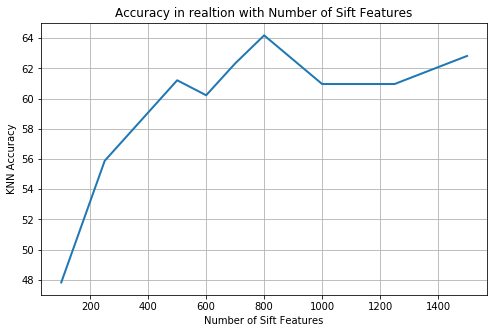

In [13]:
# PLOT CODE
plt.figure(figsize=(8, 5))
plt.title('Accuracy in realtion with Number of Sift Features')
plt.plot(sift_features,result,linewidth=2,'r')
plt.xlabel('Number of Sift Features')
plt.ylabel('KNN Accuracy')
plt.grid(True)
plt.axis('Tight')

We can see that the performance of the k-nn classifier improves with the number of SIFT features, up to a certain point. The explanation behind this is that too few features do not represent appropriately the different characteristics of each class, provided that the particular characteristics that allow discriminating between classes do not get to be considered. On the other hand,  if we include those characteristics that are not representative of the class, the number of which increases with the amount of feature points, we also do not represent each class appropriately, as certain specific characteristics of particular images in each class will be considered, which leads to a bad representation of the data. Therefore, we must find a tradeoff which, in this case, seems to yield the best results when considering a maximum of 600-800 feature points per image.

In [14]:
result = []
sift_features = [600,625,650,675,700,725,750,775,800,825,850]
for n,nosf in enumerate(sift_features):
    SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=nosf)
    Train_descriptors = []
    Train_label_per_descriptor = []
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    D=np.vstack(Train_descriptors)
    k = VOCABULARY_SIZE
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    knn = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=DISTANCE_METRIC)
    knn.fit(visual_words, train_labels)
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    result.append(100*knn.score(visual_words_test, test_labels))
    print('Configuration {0} Done.'.format(n))

Configuration 0 Done.
Configuration 1 Done.
Configuration 2 Done.
Configuration 3 Done.
Configuration 4 Done.
Configuration 5 Done.
Configuration 6 Done.
Configuration 7 Done.
Configuration 8 Done.
Configuration 9 Done.
Configuration 10 Done.


(587.5, 862.5, 60.024783147459736, 64.38661710037175)

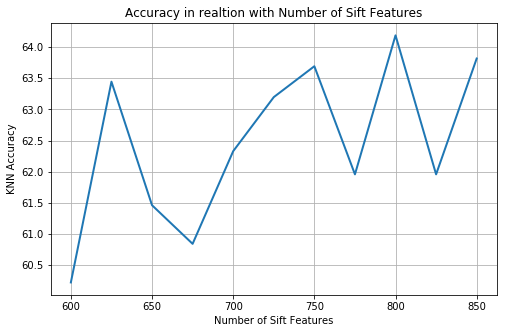

In [17]:
# PLOT CODE
plt.figure(figsize=(8, 5))
plt.title('Accuracy in realtion with Number of Sift Features')
plt.plot(sift_features,result,linewidth=2)
plt.xlabel('Number of Sift Features')
plt.ylabel('KNN Accuracy')
plt.grid(True)
plt.axis('Tight')

PCA

In [ ]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=DISTANCE_METRIC)
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=64)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=DISTANCE_METRIC)
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

In [ ]:
# CODE SNIPPET FOR DENSE SIFT
img = skid.lena()
gray= cv2.cvtColor(img ,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

step_size = 5
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                    for x in range(0, gray.shape[1], step_size)]
kp,des = sift.compute(gray, kp)

In [ ]:
# CODE SNIPPET FOR DENSE SIFT V2 (OPENCV VERSION 2.4.6 TRY OTHER)
dense = cv2.FeatureDetector_create("Dense")
kp = dense.detect(imgGray)
kp,des=sift.compute(imgGray,kp)